<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook walks you through the process of fine-tuning a Segment Anything Model (SAM) using custom data**.
<p>

**What is SAM?**
<br>
SAM is an image segmentation model developed by Meta AI. It was trained over 11 billion segmentation masks from millions of images. It is designed to take human prompts, in the form of points, bounding boxes or even a text prompt describing what should be segmented.
<p>

**What are the key features of SAM?**
<br>

* **Zero-shot generalization:** SAM can be used to segment objects that it has never seen before, without the need for additional training.

* **Flexible prompting:** SAM can be prompted with a variety of input, including points, boxes, and text descriptions.

* **Real-time mask computation:** SAM can generate masks for objects in real time. This makes SAM ideal for applications where it is necessary to segment objects quickly, such as autonomous driving and robotics.

* **Ambiguity awareness:** SAM is aware of the ambiguity of objects in images. This means that SAM can generate masks for objects even when they are partially occluded or overlapping with other objects.

<p>

**How does SAM work?**
<br>
SAM works by first encoding the image into a high-dimensional vector representation. The prompt is encoded into a separate vector representation. The two vector representations are then combined and passed to a mask decoder, which outputs a mask for the object specified by the prompt.
<p>
The image encoder is a vision transformer (ViT-H) model, which is a large language model that has been pre-trained on a massive dataset of images. The prompt encoder is a simple text encoder that converts the input prompt into a vector representation. The mask decoder is a lightweight transformer model that predicts the object mask from the image and prompt embeddings.
<p>

**SAM paper:** https://arxiv.org/pdf/2304.02643.pdf​
<p>




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ai2rn_8k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ai2rn_8k
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=fcec14b4af6af9c1f957de43ce657742829219a5774caf1f925ba5c391b4b0e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-hzi0bgd7/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
# from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

In [4]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [5]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
IMG_COUNT = 480

In [6]:
# set this between [1, 10] for differently composed datasets
# reference: https://arxiv.org/pdf/2307.05911.pdf
TRAINING_SET = 1

In [7]:
# # extract data from zip file
# import zipfile
# import os

# # Define the path to your zip file and the directory where you want to extract it
# zip_file_path = '/content/drive/MyDrive/465 Project/archive.zip'
# extract_folder_path = '/content/drive/MyDrive/465 Project/Dataset'

# os.makedirs(extract_folder_path, exist_ok=True)

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_folder_path)

In [8]:
images = []
masks = []

target_size = (IMG_WIDTH, IMG_HEIGHT)
# 100% Manually Segmented
print("Selected Training Set 1")
print("Manually Segmented - 100% (480)")

image_dir = '/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET/RG'
mask_dir = '/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET/RGMask'

# Iterate through the directories and load the images and masks

for file in sorted(os.listdir(image_dir)):
    # Load the image and resize to the target size
    img = cv2.imread(os.path.join(image_dir, file))
    img = cv2.resize(img, target_size)

    # Append the resized image to the list of images
    images.append(img)

for file in sorted(os.listdir(mask_dir)):

    # Load the corresponding mask and resize to the target size
    mask = cv2.imread(os.path.join(mask_dir, file))
    mask = cv2.resize(mask, target_size)

    # Append the resized mask to the list of masks
    masks.append(mask)

IMG_COUNT = len(images)
print(IMG_COUNT)
print(len(masks))

Selected Training Set 1
Manually Segmented - 100% (480)
480
480


In [9]:
images = np.array(images)
masks = np.array(masks)
print(images.shape, masks.shape)
# change the Y to a boolean
masks = np.where(masks > 245, True, False)

(480, 256, 256, 3) (480, 256, 256, 3)


In [10]:
# careful to run this cell only once (otherwise shape changes)
images = np.transpose(images, (0, 3, 1 , 2))
masks = np.transpose(masks, (0, 3, 1 , 2))
print(images.shape, masks.shape)

(480, 3, 256, 256) (480, 3, 256, 256)


In [11]:
#convert the boolean where it insion s true (any of the 3 channels) to a (336, 128, 128, 1)
#basically reduce the 3 channel dimeRGB to just one boolean value

masks= np.any(masks, axis=1)
print(masks.shape)
masks = masks.reshape(IMG_COUNT, 1, IMG_HEIGHT, IMG_WIDTH)
print(masks.shape)


(480, 256, 256)
(480, 1, 256, 256)


In [42]:
from torch.utils.data import Dataset

class GrainDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).float()
        mask = torch.from_numpy(self.masks[idx]).float()
        return image, mask

# Create the dataset
dataset = GrainDataset(images, masks)

In [43]:
dataset, len(dataset)

(<__main__.GrainDataset at 0x799104ba0760>, 480)

Let us make sure out images and masks (labels) are loading appropriately

torch.Size([256, 256, 3]) torch.Size([256, 256, 1])


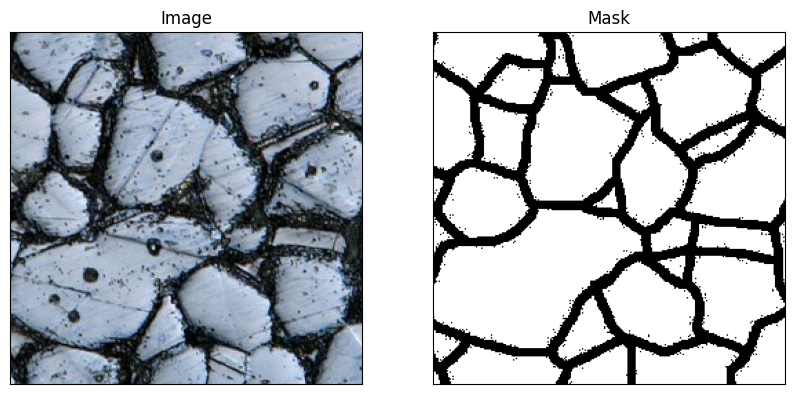

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import array


img_num = np.random.randint(0, images
.shape[0]-1)
example_image ,example_mask = dataset[img_num]

example_image = example_image.permute(1, 2, 0)
example_mask = example_mask.permute(1, 2, 0)


print(example_image.shape, example_mask.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image (assuming it's RGB) on the left
axes[0].imshow(example_image.numpy().astype(np.uint8))
axes[0].set_title("Image")

# Plot the second image (assuming it's grayscale) on the right
axes[1].imshow(example_mask.numpy().astype(np.uint8), cmap='gray')
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


Get bounding boxes from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [46]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map[0] > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map[0].shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [47]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item[0]
    ground_truth_mask = np.array(item[1])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [48]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [49]:
from torch.utils.data import random_split

# Split the dataset into train and validation sets (80-10-10)
train_size = int(0.80 * len(dataset))
r = len(dataset) - train_size
val_size = int(0.5 * r)
test_size = int(0.5 * r)
train_dataset_, val_dataset_,test_dataset_ = random_split(dataset, [train_size, val_size,test_size])

In [50]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=train_dataset_, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset_, processor=processor)
test_dataset = SAMDataset(dataset=test_dataset_, processor=processor)


In [52]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (1, 256, 256)


In [53]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True, drop_last=False)

In [54]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 1, 256, 256])


In [55]:
batch["ground_truth_mask"].shape

torch.Size([2, 1, 256, 256])

In [56]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [57]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [58]:
from tqdm import tqdm
from statistics import mean
import torch

# Early Stopping Setup
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait after min has been hit. Change as per requirement.
patience_counter = 0

# Training loop
num_epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(num_epochs):
    print(f'EPOCH: {epoch}')
    epoch_losses = []
    model.train()  # Ensure the model is in training mode

    for batch in tqdm(train_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    mean_train_loss = mean(epoch_losses)
    print(f'Mean training loss: {mean_train_loss}')

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            # Forward pass
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            # Compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks)
            val_losses.append(loss.item())

    mean_val_loss = mean(val_losses)
    print(f'Mean validation loss: {mean_val_loss}')

    # Early Stopping Condition
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        patience_counter = 0
        print("Best model saved with validation loss: {:.4f}".format(best_val_loss))
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")
        if patience_counter >= patience:
            print("Stopping early due to no improvement in validation loss.")
            break


EPOCH: 0


100%|██████████| 192/192 [02:59<00:00,  1.07it/s]


Mean training loss: 0.47982187382876873
Mean validation loss: 0.45455995947122574
Best model saved with validation loss: 0.4546
EPOCH: 1


100%|██████████| 192/192 [03:08<00:00,  1.02it/s]


Mean training loss: 0.4458018681034446
Mean validation loss: 0.43784141167998314
Best model saved with validation loss: 0.4378
EPOCH: 2


100%|██████████| 192/192 [03:05<00:00,  1.03it/s]


Mean training loss: 0.4332060981541872
Mean validation loss: 0.42855064819256466
Best model saved with validation loss: 0.4286
EPOCH: 3


100%|██████████| 192/192 [03:05<00:00,  1.03it/s]


Mean training loss: 0.4252591226249933
Mean validation loss: 0.4233521595597267
Best model saved with validation loss: 0.4234
EPOCH: 4


100%|██████████| 192/192 [03:06<00:00,  1.03it/s]


Mean training loss: 0.41922723160435754
Mean validation loss: 0.4193214923143387
Best model saved with validation loss: 0.4193
EPOCH: 5


100%|██████████| 192/192 [03:05<00:00,  1.03it/s]


Mean training loss: 0.4153508433761696
Mean validation loss: 0.4164494536817074
Best model saved with validation loss: 0.4164
EPOCH: 6


100%|██████████| 192/192 [03:06<00:00,  1.03it/s]


Mean training loss: 0.41346904387076694
Mean validation loss: 0.4132424133519332
Best model saved with validation loss: 0.4132
EPOCH: 7


100%|██████████| 192/192 [03:05<00:00,  1.03it/s]


Mean training loss: 0.41207287553697824
Mean validation loss: 0.41312821209430695
Best model saved with validation loss: 0.4131
EPOCH: 8


100%|██████████| 192/192 [03:05<00:00,  1.03it/s]


Mean training loss: 0.40861466837426025
Mean validation loss: 0.410593635092179
Best model saved with validation loss: 0.4106
EPOCH: 9


100%|██████████| 192/192 [03:05<00:00,  1.03it/s]


Mean training loss: 0.40732262423262
Mean validation loss: 0.4099210935334365
Best model saved with validation loss: 0.4099
EPOCH: 10


100%|██████████| 192/192 [03:05<00:00,  1.03it/s]


Mean training loss: 0.4061309041765829
Mean validation loss: 0.4083910385767619
Best model saved with validation loss: 0.4084
EPOCH: 11


100%|██████████| 192/192 [03:05<00:00,  1.03it/s]


Mean training loss: 0.40532104050119716
Mean validation loss: 0.4065088766316573
Best model saved with validation loss: 0.4065
EPOCH: 12


100%|██████████| 192/192 [03:05<00:00,  1.03it/s]


Mean training loss: 0.40397487782562774
Mean validation loss: 0.40824980661273
No improvement in validation loss for 1 epochs.
EPOCH: 13


100%|██████████| 192/192 [03:05<00:00,  1.03it/s]


Mean training loss: 0.40398109223072726
Mean validation loss: 0.4058955597380797
Best model saved with validation loss: 0.4059
EPOCH: 14


100%|██████████| 192/192 [03:05<00:00,  1.03it/s]


Mean training loss: 0.40279288015638787
Mean validation loss: 0.4055514472226302
Best model saved with validation loss: 0.4056
EPOCH: 15


100%|██████████| 192/192 [03:05<00:00,  1.03it/s]


Mean training loss: 0.4028651691041887
Mean validation loss: 0.40467813486854237
Best model saved with validation loss: 0.4047
EPOCH: 16


100%|██████████| 192/192 [03:05<00:00,  1.04it/s]


Mean training loss: 0.40201924880966544
Mean validation loss: 0.404725073526303
No improvement in validation loss for 1 epochs.
EPOCH: 17


100%|██████████| 192/192 [03:05<00:00,  1.03it/s]


Mean training loss: 0.40161915123462677
Mean validation loss: 0.4042204183836778
Best model saved with validation loss: 0.4042
EPOCH: 18


100%|██████████| 192/192 [03:05<00:00,  1.03it/s]


Mean training loss: 0.40112138927603763
Mean validation loss: 0.4044401943683624
No improvement in validation loss for 1 epochs.
EPOCH: 19


100%|██████████| 192/192 [03:05<00:00,  1.03it/s]


Mean training loss: 0.40089085154856247
Mean validation loss: 0.4059535600244999
No improvement in validation loss for 2 epochs.


In [59]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/465 Project/SAM Checkpoints/SAM segmentation grain-1(10 epch 80-10-10 split).pth")

**Inference**

In [60]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [61]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_grain_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_grain_model.load_state_dict(torch.load("/content/drive/MyDrive/465 Project/SAM Checkpoints/SAM segmentation grain-1(10 epch 80-10-10 split).pth"))

<All keys matched successfully>

In [62]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_grain_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

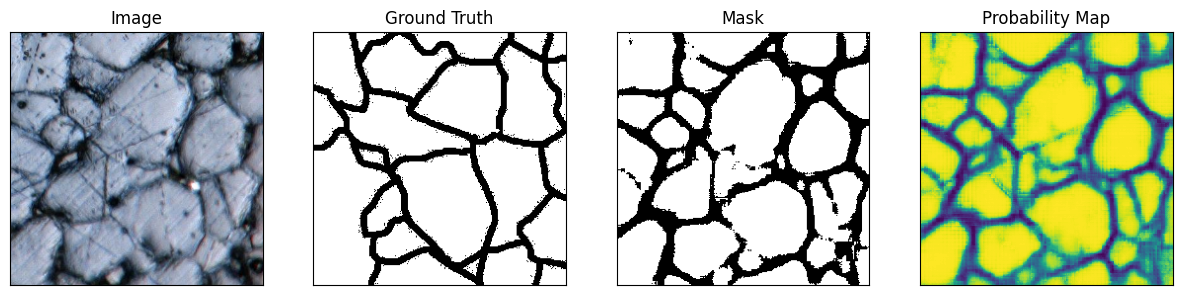

In [63]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, len(test_dataset_)-1)

# load image
test_image = test_dataset_[idx][0]
test_mask = test_dataset_[idx][1]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx][1])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_grain_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_grain_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(test_image.permute(1, 2, 0).numpy().astype(np.uint8))
axes[0].set_title("Image")

axes[1].imshow(test_mask.permute(1, 2, 0).numpy().astype(np.uint8), cmap='gray')
axes[1].set_title("Ground Truth")

# Plot the second image on the right
axes[2].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Mask")

# Plot the second image on the right
axes[3].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[3].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


In [64]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 3.8 MB/s eta 0:00:00


In [65]:
test_dataloader = DataLoader(val_dataset,batch_size=2, shuffle=False, drop_last=False)

from torchmetrics.functional import dice

total_dice_score = 0.0
total_num_samples = 0

cnt = 0
for batch in tqdm(test_dataloader):
    cnt+=1
    with torch.no_grad():

        # forward pass
        outputs = my_grain_model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)

        for ind in range(len(predicted_masks)):
            pred_tensor = (predicted_masks[ind] > 0.5).float()
            gt_tensor = ground_truth_masks[ind].to(torch.int64)  # Convert mask tensor to integer tensor

            dice_score = dice(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

total_num_samples = 2*cnt

average_dice_score = total_dice_score / total_num_samples

print(f"Training set: {TRAINING_SET}")
print(f"Total Number samples: {total_num_samples}")
print(f"Average Dice Score: {average_dice_score}")

100%|██████████| 24/24 [00:26<00:00,  1.08s/it]

Training set: 1
Total Number samples: 48
Average Dice Score: 0.8791230854888757
